# Kalman Filter Class Development

In [1]:
from __future__ import annotations

from abc import ABC, abstractmethod
from typing import Optional, Protocol

import numpy as np
from numpy.typing import NDArray

import matplotlib.pyplot as plt

# 1 - SystemModel

`SystemModel` defines the minimum interface a Kalman filter can rely on. Any model must
provide `Q(dt)` (process noise, n x n) and `R()` (measurement noise, m x m). These two form the
core contract required by all filters.

Specific filter types depend on additional model methods: LKF requires `F(dt)` and `H()`;
EKF requires `f`, `h`, and their Jacobians; UKF requires `f` and `h`. A model only needs to
implement the subset required by the filter being used.

The Protocol itself has no runtime logic—it simply formalizes the structure the filter
expects. Testing focuses on model implementations (valid and invalid) and on ensuring that
filters correctly consume these methods. This separation keeps the filter generic and lets
any well-formed model be plugged in without modifying the filter code.

In [2]:
class SystemModel(Protocol):
    """
    Contract for system models used by Kalman-type filters.
    LKF is Linear Kalman Filter
    EKF is Extended Kalman Filter
    UKF is Unscented Kalman Filter

    Every model MUST provide:
        Q(dt) : process noise covariance (n x n)
        R()   : measurement noise covariance (m x m)

    Additional methods required by specific filters:

    LKF:
        F(dt)       : state transition matrix (n x n)
        H()         : measurement matrix     (m x n)

    EKF:
        f(x, u, dt)           : nonlinear state transition (n,)
        h(x)                  : nonlinear measurement model (m,)
        F_jacobian(x, u, dt)  : Jacobian of f wrt x (n x n)
        H_jacobian(x)         : Jacobian of h wrt x (m x n)

    UKF:
        f(x, u, dt)           : nonlinear state transition (n,)
        h(x)                  : nonlinear measurement model (m,)


    ---- REQUIRED BASE METHODS ----

    Q(dt):
        Input:
            dt: float
                Time step between k and k+1
        Output:
            ndarray (n x n)
                Process noise covariance evaluated for dt.

    R():
        Input: None
        Output:
            ndarray (m x m)
                Measurement noise covariance.

    A model may optionally implement the linear or nonlinear interfaces
    depending on which Kalman filter variant it will be used with.
    """

    def Q(self, dt: float) -> NDArray[np.float64]:
        ...

    def R(self) -> NDArray[np.float64]:
        ...

# 2 - BaseKalmanFilter

This base class defines the reusable structure shared by all Kalman filter
variants. It does not contain any filtering equations. The goal is to avoid
rewriting the same state storage, input validation, and predict/update calling
logic across LinearKF, EKF, and UKF.

The separation of responsibilities is intentional:

- The **SystemModel** defines the system’s behaviour: the state dynamics,
  the measurement relationship, and the noise covariances (Q and R).
  Different physical systems (e.g., spacecraft, vehicles, sensors) implement
  their own SystemModel.

- **BaseKalmanFilter** provides the common scaffold: it stores the state `x`
  and covariance `P`, exposes unified methods (`predict`, `update`, `step`),
  and enforces that subclasses supply the actual filtering mathematics.

- Each concrete filter (**LinearKF**, **EKF**, **UKF**) implements its own math
  inside `_predict_impl` and `_update_impl`, using the functions supplied by
  the model (e.g., F/H for linear systems or f/h for nonlinear systems).

As a result, the Kalman filter logic is cleanly separated from the system
dynamics. Any well-formed SystemModel can be paired with any Kalman filter
variant without modifying the filter code.


In [3]:
class BaseKalmanFilter(ABC):
    """
    Abstract base class for all Kalman filter variants.

    This class provides the common structure shared by LinearKF, EKF, and UKF:
      - storage for the state estimate (x) and covariance (P)
      - a reference to the system model, which supplies Q(dt), R(), and any
        additional functions required by the specific filter variant
      - the standard external interface: predict(), update(), and step()
      - input validation for initial state and covariance dimensions

    The class does *not* implement any Kalman filtering mathematics. Subclasses
    must implement the two internal methods:
        _predict_impl(u, dt)
        _update_impl(z)
    These methods perform the actual prediction and measurement-update steps
    using the model’s linear or nonlinear functions.

    Parameters
    ----------
    model : SystemModel
        Object implementing the SystemModel protocol. Must provide Q(dt), R(),
        and any additional methods required by the chosen filter variant.
    x0 : ndarray (n,)
        Initial state estimate.
    P0 : ndarray (n, n)
        Initial covariance estimate.

    Notes
    -----
    This class is abstract (inherits from ABC) and cannot be instantiated
    directly. It serves as the template and shared foundation for all Kalman
    filter implementations.
    """    
    def __init__(
        self,
        model: "SystemModel",
        x0: NDArray[np.float64],
        P0: NDArray[np.float64]
    ) -> None:
        
        # Store model reference
        self.model = model

        # Convert and validate shapes
        x0 = np.atleast_1d(np.asarray(x0, dtype=float))
        P0 = np.atleast_2d(np.asarray(P0, dtype=float))

        if x0.ndim != 1:
            raise ValueError("x0 must be a 1D state vector.")
        if P0.shape[0] != P0.shape[1]:
            raise ValueError("P0 must be a square (n x n) matrix.")
        if P0.shape[0] != x0.shape[0]:
            raise ValueError("Dimension mismatch: P0 must match length of x0.")

        self.x = x0.copy()    # Current state estimate x_hat(n, n)
        self.P = P0.copy()    # Current covariance estimate, size n x n
        self.n = len(x0)      # State dimension

        self._last_innovation = None    # Measuremnt residual (z - z_pred)
        self._last_S = None             # innovation covariance

    # ----------------------------------------------------------------------
    # External interface
    # ----------------------------------------------------------------------

    def predict(
        self,
        u: Optional[NDArray[np.float64]] = None,
        dt: Optional[float] = None,
    ) -> None:
        """Run the prediction step."""
        self._predict_impl(u=u, dt=dt)

    def update(self, z: NDArray[np.float64]) -> None:
        """Run the measurement update step."""
        z = np.atleast_1d(np.asarray(z, dtype=float))
        self._update_impl(z=z)

    def step(
        self,
        z: NDArray[np.float64],
        u: Optional[NDArray[np.float64]] = None,
        dt: Optional[float] = None,
    ) -> None:
        """Convenience method: perform predict() followed by update()."""
        self.predict(u=u, dt=dt)
        self.update(z=z)

    # ----------------------------------------------------------------------
    # Accessors
    # ----------------------------------------------------------------------

    @property
    def state(self) -> NDArray[np.float64]:
        """Return a copy of the current state estimate."""
        return self.x.copy()

    @property
    def covariance(self) -> NDArray[np.float64]:
        """Return a copy of the current covariance estimate."""
        return self.P.copy()

    # ----------------------------------------------------------------------
    # Subclass-required methods
    # ----------------------------------------------------------------------

    @abstractmethod
    def _predict_impl(
        self,
        u: Optional[NDArray[np.float64]],
        dt: Optional[float],
    ) -> None:
        """
        Subclass-specific prediction logic.
        Must update self.x and self.P in-place.
        """
        pass

    @abstractmethod
    def _update_impl(self, z: NDArray[np.float64]) -> None:
        """
        Subclass-specific measurement update logic.
        Must update self.x and self.P in-place.
        May optionally record innovation diagnostics.
        """
        pass
    

# 3 - LKF

In [4]:
class LinearKF(BaseKalmanFilter):
    """
    Linear Kalman Filter for time-varying linear-Gaussian systems.

    Model form (matching Becker's notation, ASCII only):

        x_{n+1} = F_n x_{n,n} + G_n u_n + w_n       (state extrapolation)
        z_n     = H_n x_n       + v_n               (measurement equation)

    where
        w_n ~ N(0, Q_n)    process noise
        v_n ~ N(0, R_n)    measurement noise

    Filter equations
    ----------------

    Predict (time update)

        State extrapolation:
            x_hat_{n+1|n} = F_n x_hat_{n|n} + G_n u_n

        Covariance extrapolation:
            P_{n+1|n} = F_n P_{n|n} F_n^T + Q_n

    Update (measurement correction)

        Innovation (residual):
            y_n = z_n - H_n x_hat_{n|n-1}

        Innovation covariance:
            S_n = H_n P_{n|n-1} H_n^T + R_n

        Kalman gain:
            K_n = P_{n|n-1} H_n^T S_n^{-1}

        State update:
            x_hat_{n|n} = x_hat_{n|n-1} + K_n y_n

        Covariance update (Joseph form for numerical stability):
            P_{n|n} = (I - K_n H_n) P_{n|n-1} (I - K_n H_n)^T + K_n R_n K_n^T

    Model requirements
    ------------------
    The `model` passed to this filter must implement:

        F(dt) -> ndarray (n, n)
            State transition matrix F_n for timestep dt.

        H()   -> ndarray (m, n)
            Measurement matrix H_n.

        Q(dt) -> ndarray (n, n)
            Process noise covariance Q_n for timestep dt.

        R()   -> ndarray (m, m)
            Measurement noise covariance R_n.

    Optionally, if a control input u is used:

        G(dt) -> ndarray (n, r)
            Control input matrix G_n for timestep dt, used with u_n (r,).

    Notes
    -----
    External code calls predict(u, dt) and update(z), or step(z, u, dt).
    The internal methods _predict_impl and _update_impl implement the
    equations above using the model's matrices.
    """

    def _predict_impl(
        self,
        u: Optional[NDArray[np.float64]],
        dt: Optional[float],
    ) -> None:
        if dt is None:
            raise ValueError("LinearKF.predict() requires a time step dt.")

        # State extrapolation:
        #   x_hat_{n+1|n} = F_n x_hat_{n|n} + G_n u_n
        F = self.model.F(dt)          # (n, n)
        Q = self.model.Q(dt)          # (n, n)

        x_pred = F @ self.x           # state extrapolation

        # Optional control term G_n u_n
        if u is not None:
            if not hasattr(self.model, "G"):
                raise AttributeError(
                    "Control input u was provided, but model does not define G(dt)."
                )
            G = self.model.G(dt)      # (n, r)
            u = np.atleast_1d(np.asarray(u, dtype=float))
            x_pred = x_pred + G @ u

        # Covariance extrapolation:
        #   P_{n+1|n} = F_n P_{n|n} F_n^T + Q_n
        P_pred = F @ self.P @ F.T + Q

        self.x = x_pred
        self.P = P_pred

    def _update_impl(self, z: NDArray[np.float64]) -> None:
        # Measurement model:
        #   z_n = H_n x_n + v_n
        H = self.model.H()            # (m, n)
        R = self.model.R()            # (m, m)

        # Innovation (residual):
        #   y_n = z_n - H_n x_hat_{n|n-1}
        y = z - H @ self.x

        # Innovation covariance:
        #   S_n = H_n P_{n|n-1} H_n^T + R_n
        S = H @ self.P @ H.T + R

        # Kalman gain:
        #   K_n = P_{n|n-1} H_n^T S_n^{-1}
        K = self.P @ H.T @ np.linalg.inv(S)

        # State update:
        #   x_hat_{n|n} = x_hat_{n|n-1} + K_n y_n
        x_upd = self.x + K @ y

        # Covariance update (Joseph form):
        #   P_{n|n} = (I - K H) P_{n|n-1} (I - K H)^T + K R K^T
        I = np.eye(self.n)
        I_minus_KH = I - K @ H
        P_upd = I_minus_KH @ self.P @ I_minus_KH.T + K @ R @ K.T

        self.x = x_upd
        self.P = P_upd

        # Store diagnostics
        self._last_innovation = y
        self._last_S = S

In [5]:
# 1D constant-temperature model matching Becker Example 6
class ConstantTempModel:
    """
    1D model: x_n = T + w_n,  z_n = x_n + v_n
    For the filter, this is equivalent to:
        F = 1, H = 1, Q = q, R = r
    """

    def __init__(self, q: float, r: float) -> None:
        self.q = float(q)  # process noise variance
        self.r = float(r)  # measurement noise variance

    def F(self, dt: float) -> NDArray[np.float64]:
        return np.array([[1.0]])

    def H(self) -> NDArray[np.float64]:
        return np.array([[1.0]])

    def Q(self, dt: float) -> NDArray[np.float64]:
        # q does not depend on dt in this example
        return np.array([[self.q]])

    def R(self) -> NDArray[np.float64]:
        return np.array([[self.r]])

# True temperature values at measurement times (due to process noise)
true_temps = np.array([
    50.005, 49.994, 49.993, 50.001, 50.006,
    49.998, 50.021, 50.005, 50.000, 49.997
])

# Measured temperatures
measurements = np.array([
    49.986, 49.963, 50.090, 50.001, 50.018,
    50.050, 49.938, 49.858, 49.965, 50.114
])

n_meas = len(measurements)
indices = np.arange(1, n_meas + 1)  # measurement number 1..10

# Kalman filter parameters from Becker Example 6
q = 0.0001      # process noise variance
sigma_r = 0.1   # measurement std dev
r = sigma_r**2  # measurement variance

# Initialization from the text
x0 = np.array([60.0])         # initial estimate
P0 = np.array([[100.0**2]])   # initial covariance

model = ConstantTempModel(q=q, r=r)
kf = LinearKF(model=model, x0=x0, P0=P0)

estimates = []
sigmas = []
gains = []

dt = 5.0  # seconds between measurements (not used in F/Q here)

for z in measurements:
    # Predict step: x_{n+1|n}, P_{n+1|n}
    kf.predict(dt=dt)

    # For logging the Kalman gain, compute it from predicted P
    P_pred = kf.covariance.copy()      # P_{n|n-1}
    H = model.H()
    Rmat = model.R()
    S = H @ P_pred @ H.T + Rmat        # innovation covariance
    K = P_pred @ H.T @ np.linalg.inv(S)
    gains.append(K.item())

    # Update step with measurement z_n
    kf.update(np.array([z]))

    # Store posterior estimate and covariance
    x_post = kf.state[0]
    P_post = kf.covariance[0, 0]

    estimates.append(x_post)
    sigmas.append(np.sqrt(P_post))

estimates = np.array(estimates)
sigmas = np.array(sigmas)

# 95% confidence interval = estimate +/- 1.96 * sigma
ci_upper = estimates + 1.96 * sigmas
ci_lower = estimates - 1.96 * sigmas


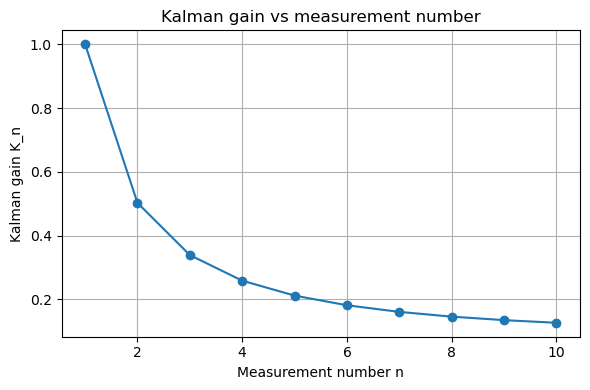

In [6]:
plt.figure(figsize=(6, 4))
plt.plot(indices, gains, marker="o")
plt.xlabel("Measurement number n")
plt.ylabel("Kalman gain K_n")
plt.title("Kalman gain vs measurement number")
plt.grid(True)
plt.tight_layout()
plt.show()


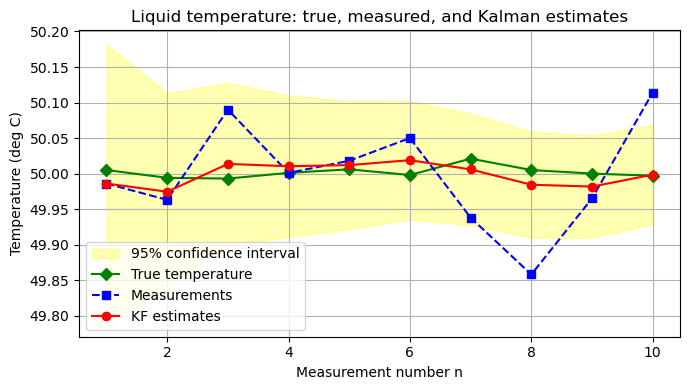

In [7]:
plt.figure(figsize=(7, 4))

# 95% confidence band around the estimates
plt.fill_between(
    indices, ci_lower, ci_upper,
    color="yellow", alpha=0.3, label="95% confidence interval"
)

# True temperatures (green, diamond marker)
plt.plot(
    indices, true_temps,
    color="green", marker="D", linestyle="-", label="True temperature"
)

# Measurements (blue, square marker)
plt.plot(
    indices, measurements,
    color="blue", marker="s", linestyle="--", label="Measurements"
)

# Kalman estimates (red, circle marker)
plt.plot(
    indices, estimates,
    color="red", marker="o", linestyle="-", label="KF estimates"
)

plt.xlabel("Measurement number n")
plt.ylabel("Temperature (deg C)")
plt.title("Liquid temperature: true, measured, and Kalman estimates")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# 4 - EKF

# 5 - UKF